# Toy Problem Optimization

This notebook explores what happens when you take the two-link rope toy problem and pull the rope only towards increase X, which is easy

In [1]:
import notebook_finder
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=2)
import toy_problem_optimization_common as tpo
from toy_problem_optimization_common import BOLD
np.random.seed(0)

importing Jupyter notebook from toy_problem_optimization_common.ipynb


### Define goal

Our goal will be denoted as $g$, for now we simply assume its defined in the full state space

In [2]:
g = np.array([[5], [0], [6], [0]])

# Manual Data

Let's pretend our data comes from pulling a 2-link object to the right for 6 time steps

In [3]:
manual_data = []
manual_dt = 0.1
for x1 in np.arange(0, 5, manual_dt):
    y = 0 #np.random.randint(-10,10)
    # Training data looks like [(s_t, u_t, s_{t+1}, c_t, c_{t+1})]
    manual_data.append((np.array([[x1],[y],[x1+1],[y]]),
         np.array([[1],[0]]),
         np.array([[x1+manual_dt],[y],[x1+1+manual_dt],[y]]),
         np.array([[(g[0] - x1)**2]]),
         np.array([[(g[0] - (x1+manual_dt))**2]])))

### X Model (Perfect)

This model reduces the full state to just $x_1$. The dynamics are $\dot{o}=v_x$, and the cost is simply the squared difference $(g - x_1)^2$

In [4]:
x_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
x_model.from_params([1, 0, 0, 0, 0, 1, 0, 1])
BOLD("X Model Loss:")
x_eval = tpo.eval_model(x_model, manual_data, g, manual_dt, print_model=False)

**X Model Loss:**

Loss Components:
	current cost: 0.0
	predict next latent state: 0.0
	predict next cost: 0.0
	regularization: 1.7320508075688774e-05
Complete Losses:
	predict next latent state and current cost: 1.7320508075688774e-05
	predict next cost and current cost: 1.7320508075688774e-05


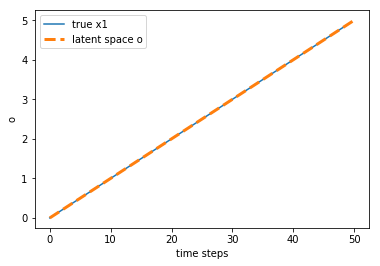

Predicted cost of rollout [[429.25]]


In [6]:
s0 = np.array([[0], [0], [1], [0]])
x_model_rollout_predicted_cost = tpo.plot_x_rollout(x_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", x_model_rollout_predicted_cost)

### Model with all zeros

We expect this to be bad

In [7]:
zero_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
zero_model.from_params(np.zeros(8))
BOLD("Zero Model Loss:")
zero_eval = tpo.eval_model(zero_model, manual_data, g, manual_dt, print_model=False)

**Zero Model Loss:**

Loss Components:
	current cost: 131.33333
	predict next latent state: 0.0
	predict next cost: 118.83333
	regularization: 0.0
Complete Losses:
	predict next latent state and current cost: 65.666665
	predict next cost and current cost: 125.08332999999999


### Y Model

reduces to just $y_1$, and says $\dot{o}=v_y$, and cost is $(g-y_1)^2$

we expect this to be bad.

In [8]:
y_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
y_model.from_params([0, 1, 0, 0, 0, 0, 1, 1])
BOLD("Y Model Loss:")
y_eval = tpo.eval_model(y_model, manual_data, g, manual_dt, print_model=False)


**Y Model Loss:**

Loss Components:
	current cost: 131.33333
	predict next latent state: 0.0
	predict next cost: 118.83333
	regularization: 1.7320508075688774e-05
Complete Losses:
	predict next latent state and current cost: 65.66668232050807
	predict next cost and current cost: 125.08334732050807


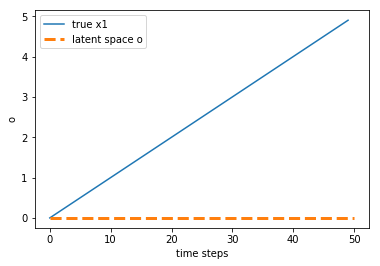

Predicted cost of rollout [[0.]]


In [10]:
s0 = np.array([[0], [0], [1], [0]])
y_model_rollout_predicted_cost = tpo.plot_x_rollout(y_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", y_model_rollout_predicted_cost)

### Random Models (average)

In [11]:
N = 1000
costs = np.zeros(N)
random_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
for i in range(N):
    random_params = np.random.randn(8)
    random_model.from_params(random_params)
    costs[i] = tpo.state_prediction_objective(random_model, g, manual_data, manual_dt)
print("Median cost for random parameters {:.3f}".format(np.median(costs)))

Median cost for random parameters 75.125


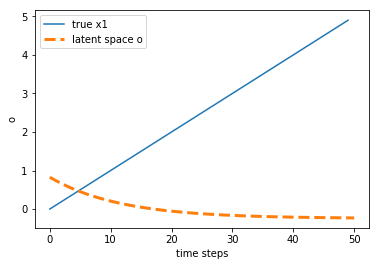

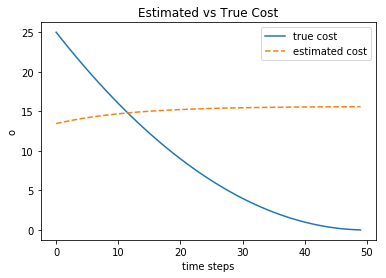

In [14]:
s0 = np.array([[0], [0], [1], [0]])
tpo.plot_x_rollout(random_model, manual_data, manual_dt, s0, g)
tpo.plot_cost(random_model, manual_data, manual_dt, g)

### Trained  Model (C Loss)

This should **NOT** work well

In [15]:
c_manual_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
BOLD("C Manual Model Loss:")
c_manual_eval = tpo.train_and_eval(c_manual_model, manual_data, g, manual_dt, tpo.cost_prediction)

**C Manual Model Loss:**

Finished in 6 iterations
Loss Components:
	current cost: 0.24512900826816847
	predict next latent state: 0.003971160399037236
	predict next cost: 4.618882226281734e-24
	regularization: 0.0002974582435605111
Complete Losses:
	predict next latent state and current cost: 0.12484754257716336
	predict next cost and current cost: 0.12286196237764474
Model reduction Matrix: [[-1.28 16.82  0.29 17.61]]
Dynamics Matrices: [[0.22]] , [[ 0.03 17.  ]]
Cost Matrix: [[0.97]]


### Trained  Model (CSP Loss)

In [16]:
csp_manual_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
BOLD("CSP Manual Model Loss:")
csp_manual_eval = tpo.train_and_eval(csp_manual_model, manual_data, g, manual_dt, tpo.state_prediction_objective)
# csp_manual_0_eval = tpo.train_and_eval(csp_manual_model, manual_data, g, manual_dt, tpo.state_prediction_objective, tpo.ZEROS)

**CSP Manual Model Loss:**

Finished in 4 iterations
Loss Components:
	current cost: 2.1324882514755152e-11
	predict next latent state: 1.5061665423451467e-06
	predict next cost: 9.515936186765245e-05
	regularization: 1.627658160680909e-05
Complete Losses:
	predict next latent state and current cost: 1.7029675540422923e-05
	predict next cost and current cost: 6.385627320307658e-05
Model reduction Matrix: [[-0.79  0.   -0.19  0.  ]]
Dynamics Matrices: [[0.01]] , [[-0.96 -0.  ]]
Cost Matrix: [[1.03]]


### Apply learned model given the actions we trained on, starting at the same initial state

Consider what happens if we follow a plan of pulling in positive X from the origin?
The true cost is the sum: $(5-0)^2+(5-0.1)^2+\dots+(5-4.9)^2+(5-5)^2$

In [17]:
# This is what we know the cost will be...
cost = 0
for x1 in np.arange(0, 5, .1):
    cost += (5-x1)**2
print(cost)

429.25000000000006


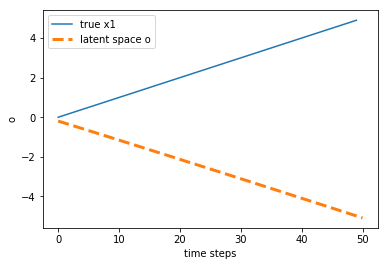

Predicted cost of rollout [[435.81]]


In [19]:
s0 = np.array([[0], [0], [1], [0]])
csp_manual_model_rollout_predicted_cost = tpo.plot_x_rollout(csp_manual_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", csp_manual_model_rollout_predicted_cost)

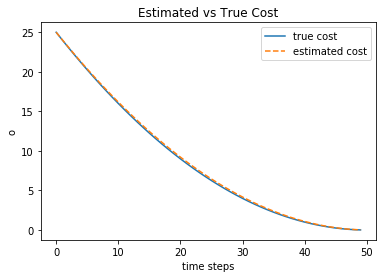

In [20]:
tpo.plot_cost(csp_manual_model, manual_data, manual_dt, g)

### Trained  Model (CCP Loss)

In [21]:
ccp_manual_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
BOLD("CCP Manual Model Loss:")
ccp_manual_eval = tpo.train_and_eval(ccp_manual_model, manual_data, g, manual_dt, tpo.one_step_cost_prediction_objective)
# ccp_manual_0_eval = tpo.train_and_eval(ccp_manual_model, manual_data, g, manual_dt, tpo.one_step_cost_prediction_objective, tpo.ZEROS)

**CCP Manual Model Loss:**

Finished in 58 iterations
Loss Components:
	current cost: 0.0003413717304691892
	predict next latent state: 2.6701009026286363e-06
	predict next cost: 0.008433560090674185
	regularization: 0.0037425844407320804
Complete Losses:
	predict next latent state and current cost: 0.0039146053564179896
	predict next cost and current cost: 0.008130050351303767
Model reduction Matrix: [[-1.33 -0.    1.28  0.  ]]
Dynamics Matrices: [[-0.18]] , [[0.16 0.  ]]
Cost Matrix: [[374.25]]


### Apply learned model given the actions we trained on, starting at the same initial state

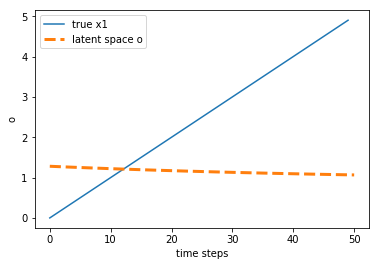

Predicted cost of rollout [[427.52]]


In [23]:
s0 = np.array([[0], [0], [1], [0]])
ccp_manual_model_rollout_predicted_cost = tpo.plot_x_rollout(ccp_manual_model, manual_data, manual_dt, s0, g)
print("Predicted cost of rollout", ccp_manual_model_rollout_predicted_cost)

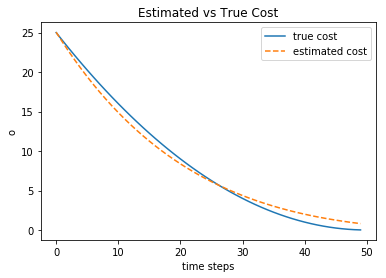

In [24]:
tpo.plot_cost(ccp_manual_model, manual_data, manual_dt, g)

# Now with some data from Gazebo

In [25]:
gazebo_fwd_data = tpo.load_gazebo_data("/home/pmitrano/catkin_ws/src/link_bot/link_bot_teleop/data/fwd_1.txt", g)
gazebo_dt = 0.1

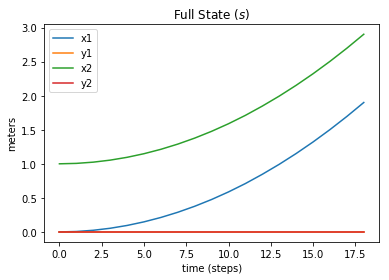

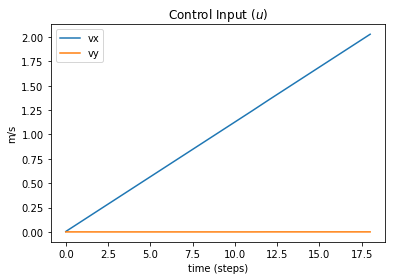

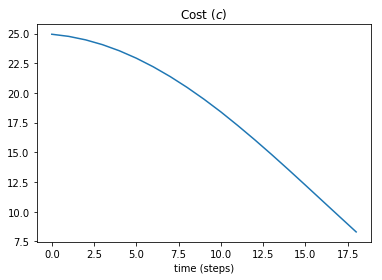

In [26]:
tpo.plot_gz_data(gazebo_fwd_data)

### See how our previous model reduction transfers

To use the same models, the dimensionality of the input data must be the same.

In [27]:
print("Use the models trained on manual synthetic data, test on new Gazebo pull data")
BOLD("CSP Model")
csp_manual_eval_on_gz = tpo.eval_model(csp_manual_model, gazebo_fwd_data, g, gazebo_dt, print_model=False)
BOLD("CCP Model")
ccp_manual_eval_on_gz = tpo.eval_model(ccp_manual_model, gazebo_fwd_data, g, gazebo_dt, print_model=False)

Use the models trained on manual synthetic data, test on new Gazebo pull data


**CSP Model**

Loss Components:
	current cost: 3.1555390845765817e-06
	predict next latent state: 0.00015287877858733613
	predict next cost: 0.009303536315726224
	regularization: 1.627658160680909e-05
Complete Losses:
	predict next latent state and current cost: 9.429374044276545e-05
	predict next cost and current cost: 0.004669622509012209


**CCP Model**

Loss Components:
	current cost: 0.0634600990914151
	predict next latent state: 0.00018777521062128422
	predict next cost: 5.205145027638741
	regularization: 0.0037425844407320804
Complete Losses:
	predict next latent state and current cost: 0.03556652159175028
	predict next cost and current cost: 2.6380451478058102


### Apply model trained on manual data to gazebo actions

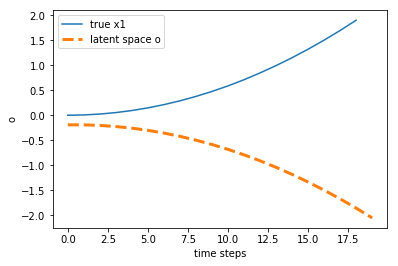

Predicted cost using CSP Manual Model of rollout in Gazebo [[379.17]]


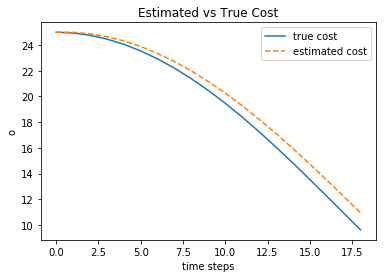

In [28]:
s0 = np.array([[0], [0], [1], [0]])
csp_manual_model_gz_rollout_predicted_cost = tpo.plot_x_rollout(csp_manual_model, gazebo_fwd_data, gazebo_dt, s0, g)
print("Predicted cost using CSP Manual Model of rollout in Gazebo", csp_manual_model_gz_rollout_predicted_cost)
tpo.plot_cost(csp_manual_model, gazebo_fwd_data, gazebo_dt, g)

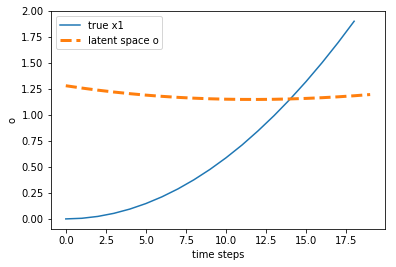

Predicted cost using CCP Manual Model of rollout in Gazebo [[196.39]]


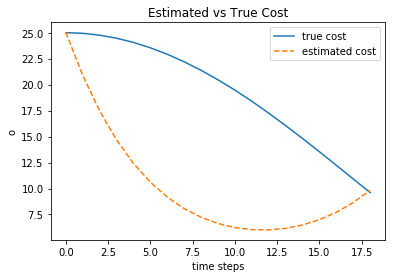

In [29]:
s0 = np.array([[0], [0], [1], [0]])
ccp_manual_model_gz_rollout_predicted_cost = tpo.plot_x_rollout(ccp_manual_model, gazebo_fwd_data, gazebo_dt, s0, g)
print("Predicted cost using CCP Manual Model of rollout in Gazebo", ccp_manual_model_gz_rollout_predicted_cost)
tpo.plot_cost(ccp_manual_model, gazebo_fwd_data, gazebo_dt, g)

### Show that our hand-designed parameters still work well

In [30]:
x_model_eval_on_gz = tpo.eval_model(x_model, gazebo_fwd_data, g, gazebo_dt, print_model=False)

Loss Components:
	current cost: 1.2323349190291226e-21
	predict next latent state: 0.00010589009081271507
	predict next cost: 0.006650774857046005
	regularization: 1.7320508075688774e-05
Complete Losses:
	predict next latent state and current cost: 7.02655534820463e-05
	predict next cost and current cost: 0.0033427079365986913


### Try to optimize on our new data

In [31]:
csp_gz_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
csp_gz_eval = tpo.train_and_eval(csp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.state_prediction_objective)
csp_gz_meta_eval = tpo.train_and_eval(csp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.state_prediction_objective, initial_params=csp_manual_model.to_params())
# csp_gz_0_eval = tpo.train_and_eval(csp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.state_prediction_objective, tpo.ZEROS)

Finished in 4 iterations
Loss Components:
	current cost: 4.0153385306288686e-05
	predict next latent state: 1.7431167149892224e-06
	predict next cost: 7.734877193466996e-05
	regularization: 3.7120987346578415e-05
Complete Losses:
	predict next latent state and current cost: 5.806923835721737e-05
	predict next cost and current cost: 9.587206596705774e-05
Model reduction Matrix: [[ 2.97  0.   -1.54  0.  ]]
Dynamics Matrices: [[-0.04]] , [[ 1.54 -0.  ]]
Cost Matrix: [[0.49]]
Finished in 2 iterations
Loss Components:
	current cost: 1.3208571750044413e-06
	predict next latent state: 1.5943622306427394e-05
	predict next cost: 0.001335354946906221
	regularization: 1.6325078743987256e-05
Complete Losses:
	predict next latent state and current cost: 2.4957318484703174e-05
	predict next cost and current cost: 0.0006846629807845999
Model reduction Matrix: [[-0.79  0.   -0.19  0.  ]]
Dynamics Matrices: [[0.12]] , [[-0.96  0.  ]]
Cost Matrix: [[1.03]]


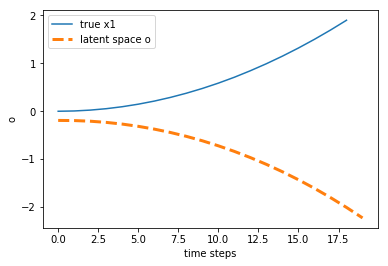

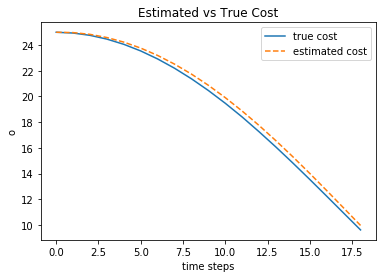

In [34]:
s0 = np.array([[0], [0], [1], [0]])
tpo.plot_x_rollout(csp_gz_model, gazebo_fwd_data, gazebo_dt, s0, g)
tpo.plot_cost(csp_gz_model, gazebo_fwd_data, gazebo_dt, g)

In [35]:
ccp_gz_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
ccp_gz_eval = tpo.train_and_eval(ccp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.one_step_cost_prediction_objective)
ccp_gz_meta_eval = tpo.train_and_eval(ccp_gz_model, gazebo_fwd_data, g, gazebo_dt, tpo.one_step_cost_prediction_objective, initial_params=ccp_manual_model.to_params())

Finished in 9 iterations
Loss Components:
	current cost: 0.0002831285388816888
	predict next latent state: 4.1738063402694356e-06
	predict next cost: 2.7892597154693044e-05
	regularization: 3.393575419506974e-05
Complete Losses:
	predict next latent state and current cost: 0.00017758692680604888
	predict next cost and current cost: 0.00018944632221326065
Model reduction Matrix: [[-1.65 -0.01  2.54 -0.  ]]
Dynamics Matrices: [[0.03]] , [[ 0.88 -0.02]]
Cost Matrix: [[1.26]]
Finished in 11 iterations
Loss Components:
	current cost: 0.016704351199864468
	predict next latent state: 8.968878638745634e-07
	predict next cost: 2.9352644499549042e-05
	regularization: 0.0035829425070986977
Complete Losses:
	predict next latent state and current cost: 0.011935566550962867
	predict next cost and current cost: 0.011949794429280704
Model reduction Matrix: [[ -1.33 -75.32   1.28  -1.34]]
Dynamics Matrices: [[0.01]] , [[-0.07  1.94]]
Cost Matrix: [[350.28]]


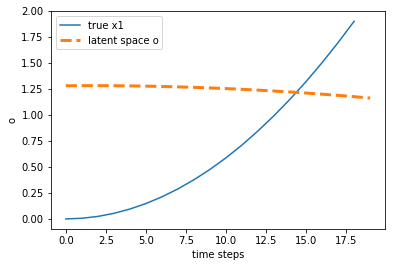

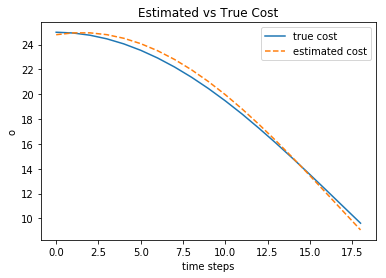

In [36]:
s0 = np.array([[0], [0], [1], [0]])
tpo.plot_x_rollout(ccp_gz_model, gazebo_fwd_data, gazebo_dt, s0, g)
tpo.plot_cost(ccp_gz_model, gazebo_fwd_data, gazebo_dt, g)

# Summary of Results On The Gazebo Pull Data

How well do each of the models do on the Gazebo pull data?

Zero here is perfect.

### Hand-Picked

|Model|Current Cost Loss|Predict State Loss|Predict Cost Loss|Regularization Loss|
|-|-|-|-|-|
|Zero model|{{zero_eval[0]}}|{{zero_eval[1]}}|{{zero_eval[2]}}|{{zero_eval[3]}}|
|Y model|{{y_eval[0]}}|{{y_eval[1]}}|{{y_eval[2]}}|{{y_eval[3]}}|
|X model|{{x_eval[0]}}|{{x_eval[1]}}|{{x_eval[2]}}|{{x_eval[3]}}|

### Trained on CSP 

|Model|Current Cost Loss|Predict State Loss|Predict Cost Loss|Regularization Loss|
|-|-|-|-|-|
|Learned Manual model|{{csp_manual_eval[0]}}|{{csp_manual_eval[1]}}|{{csp_manual_eval[2]}}|{{csp_manual_eval[3]}}|
|Transfer Learned Manual model|{{csp_manual_eval_on_gz[0]}}|{{csp_manual_eval_on_gz[1]}}|{{csp_manual_eval_on_gz[2]}}|{{csp_manual_eval_on_gz[3]}}|
|Learned Gazebo model|{{csp_gz_eval[0]}}|{{csp_gz_eval[1]}}|{{csp_gz_eval[2]}}|{{csp_gz_eval[3]}}|
|Meta-Learned gz model|{{csp_gz_meta_eval[0]}}|{{csp_gz_meta_eval[1]}}|{{csp_gz_meta_eval[2]}}|{{csp_gz_meta_eval[3]}}|


### Trained on CCP 

|Model|Current Cost Loss|Predict State Loss|Predict Cost Loss|Regularization Loss|
|-|-|-|-|-|
|Learned Manual model|{{ccp_manual_eval[0]}}|{{ccp_manual_eval[1]}}|{{ccp_manual_eval[2]}}|{{ccp_manual_eval[3]}}|
|Transfer Learned Manual model|{{ccp_manual_eval_on_gz[0]}}|{{ccp_manual_eval_on_gz[1]}}|{{ccp_manual_eval_on_gz[2]}}|{{ccp_manual_eval_on_gz[3]}}|
|Learned Gazebo model|{{ccp_gz_eval[0]}}|{{ccp_gz_eval[1]}}|{{ccp_gz_eval[2]}}|{{ccp_gz_eval[3]}}|
|Meta-Learned gz model|{{ccp_gz_meta_eval[0]}}|{{ccp_gz_meta_eval[1]}}|{{ccp_gz_meta_eval[2]}}|{{ccp_gz_meta_eval[3]}}|

One of the issues currently is that the training routine is not reproducible, as in starting from a different random vector can give very different results